### Notebook to be used to perform manual focus testing using ACCS Images

In [1]:
import numpy as np
from lsst.ts import salobj
import asyncio
from astropy.io import fits

import warnings
#import matplotlib.pyplot as plt  # imported as py above
from astropy.modeling import models, fitting
from scipy.ndimage.filters import gaussian_filter as gauss_filt
from matplotlib import pyplot as plt

import SALPY_ATCamera
#import SALPY_ATSpectrograph
import SALPY_ATArchiver

Could not import lsstcppimport; please ensure the base package has been built (not just setup).



In [2]:
#ATSpectrograph = salobj.Remote(SALPY_ATSpectrograph)
ATCamera = salobj.Remote(SALPY_ATCamera)
ATArchiver = salobj.Remote(SALPY_ATArchiver)

#### Setup the spectrograph

In [ ]:
#  bring into enable state if required
if False:
    try:
        asyncio.get_event_loop().run_until_complete(ATSpectrograph.cmd_enable.start())
    except AckError as ack_err:
        print(f"Failed with ack.result={ack_err.ack.result}")

In [3]:
ATSpectrograph.cmd_changeFilter.set(filter=0)
try:
    asyncio.get_event_loop().run_until_complete(ATSpectrograph.cmd_changeFilter.start())
except salobj.AckError as ack_err:
    print(f"Failed with ack.result={ack_err.ack.result}")


filt_pos=ATSpectrograph.evt_reportedFilterPosition.get()
print(filt_pos.position)

0


In [4]:
ATSpectrograph.cmd_changeDisperser.set(disperser=1)
asyncio.get_event_loop().run_until_complete(ATSpectrograph.cmd_changeDisperser.start())
disp_pos=ATSpectrograph.evt_reportedDisperserPosition.get()
print(disp_pos.position)

1


In [16]:
ATSpectrograph.cmd_moveLinearStage.set(distanceFromHome=5)
try:
    asyncio.get_event_loop().run_until_complete(ATSpectrograph.cmd_moveLinearStage.start())
    lin_stage_pos=asyncio.get_event_loop().run_until_complete(ATSpectrograph.evt_reportedLinearStagePosition.next(flush=False, timeout=10))
    print(lin_stage_pos)
except salobj.AckError as ack_err:
    print(f"Failed with ack.result={ack_err.ack.result}")


Failed with ack.result=Failed: Change position timed out trying to move to position 5.0.


In [17]:
lin_stage_pos=asyncio.get_event_loop().run_until_complete(ATSpectrograph.evt_reportedLinearStagePosition.next(flush=False, timeout=10))
print(lin_stage_pos)

In [13]:
print(lin_stage_pos.position)

20.0


In [5]:
if True:
    try:
        ATSpectrograph.cmd_homeLinearStage.set(value=True)
        asyncio.get_event_loop().run_until_complete(ATSpectrograph.cmd_homeLinearStage.start())
        lin_stage_pos=ATSpectrograph.evt_reportedLinearStagePosition.get()
        print(lin_stage_pos.position)
    except salobj.AckError as ack_err:
        print(f"Failed with ack.result={ack_err.ack.result}")


Failed with ack.result=Failed: 'CSC' object has no attribute 'home_gs'


#### Setup the Camera

In [277]:
#  bring into enable state if required
if False:
    try:
        asyncio.get_event_loop().run_until_complete(ATCamera.cmd_enable.start())
    except AckError as ack_err:
        print(f"Failed with ack.result={ack_err.ack.result}")

In [276]:
asyncio.get_event_loop().run_until_complete(ATCamera.cmd_start.start())

AckError: Command failed with ack code -300

In [509]:
ATCamera.cmd_takeImages.set(expTime=1.0, shutter=1, numImages=1, imageSequenceName='Focus')

False

In [666]:
try:
    asyncio.get_event_loop().run_until_complete(ATCamera.cmd_takeImages.start())
except salobj.AckError as ack_err:
    print(f"Failed with ack.result={ack_err.ack.result}")

In [667]:
endReadout = asyncio.get_event_loop().run_until_complete(ATCamera.evt_endReadout.next(flush=False, timeout=30))
print(endReadout.imageName)

AT_O_20190412_000004


In [668]:
# Read in image
#dir = '/mnt/dmcs/20180823'
dir = '/mnt/data/ats/mcm/20190412/'
#atcamera_fname='AT_O_20190403_000072'
atcamera_fname=endReadout.imageName

#dir = '/mnt/dmcs/2019-03-08/'
#atcamera_fname='AT_O_20190308_000125-ats-wfs_ccd'

full_file_name=dir+atcamera_fname+'.fits'
print('Opening {}'.format(full_file_name))
hdu_list = fits.open(full_file_name)
#hdu_list.info()
im=hdu_list[12].data # for camera data

Opening /mnt/data/ats/mcm/20190412/AT_O_20190412_000004.fits


In [669]:
#print(repr(hdu_list[0].header))

In [670]:
if False:
    im_sub=im-np.median(im)
    plt.imshow(im_sub)
    hdu_list.close()

In [671]:
# Find star by convolution with gaussian, then grab the max
star_finder_img=gauss_filt(im,[5,5],mode='constant',cval=0)

# Cut out the area with the 1st order image
half_side = 40
zero_ord_pos = [1834, 360]
ymin = zero_ord_pos[0]-half_side if zero_ord_pos[0]-half_side > 0 else 0
ymax = zero_ord_pos[0]+half_side if zero_ord_pos[0]+half_side < 2047 else 2047
xmin = zero_ord_pos[1]-half_side if zero_ord_pos[1]-half_side > 0 else 0
xmax = zero_ord_pos[1]+half_side if zero_ord_pos[1]+half_side < 512 else 512

if True:
    print('Cutting out area with zero order image')
    print('ymin,ymax,xmin,xmax = [{}, {}, {}, {}]'.format(ymin,ymax,xmin,xmax))
    star_finder_img[ymin:ymax,xmin:xmax] = -1e9 

# If the wavelength is longer than 700nm, then there will be 2nd order contamination.
# This means that the "star" finder below will find the wrong peak if the 2nd order is brighter than the first.
if True:
    print('Removing 2nd order light from star finding image')
    star_finder_img[800::,:]=0

#print(np.max(star_finder_img))
value=None
ind=np.argmax(star_finder_img)
ind2d = np.unravel_index(ind,star_finder_img.shape)
print('centroid at y,x: {} {}'.format(ind2d[0],ind2d[1]))

Cutting out area with zero order image
ymin,ymax,xmin,xmax = [1794, 1874, 320, 400]
Removing 2nd order light from star finding image
centroid at y,x: 562 379


In [672]:
# Create sub-image
#ymin=1800 ; ymax=2048
#xmin=280 ; xmax=450
half_side=int(30)
ymin = ind2d[0]-half_side if ind2d[0]-half_side > 0 else 0
ymax = ind2d[0]+half_side if ind2d[0]+half_side < 2047 else 2047
xmin = ind2d[1]-half_side if ind2d[1]-half_side > 0 else 0
xmax = ind2d[1]+half_side if ind2d[1]+half_side < 512 else 512
print('subimage being made from ymin,ymax,xmin,xmax:{} {} {} {}'.format(ymin,ymax,xmin,xmax))
# new maximum at:
ind=np.argmax(star_finder_img[ymin:ymax,xmin:xmax])
ind2d = np.unravel_index(ind,star_finder_img[ymin:ymax,xmin:xmax].shape)
print('new centroid at y,x: {} {}'.format(ind2d[0],ind2d[1]))

subimage being made from ymin,ymax,xmin,xmax:532 592 349 409
new centroid at y,x: 30 30


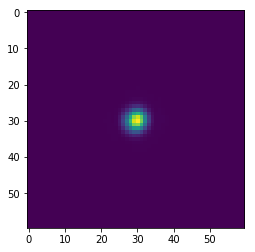

In [673]:
im_sub=im[ymin:ymax,xmin:xmax]
im_sub=im_sub-np.median(im_sub)
plt.imshow(im_sub)
hdu_list.close()

30
30


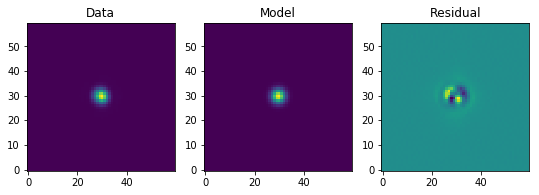

In [674]:
# Generate x,y,z data
y, x = np.mgrid[:im_sub.shape[0], :im_sub.shape[1]]
print(y[ind2d])
print(x[ind2d])
z=im_sub
# Fit the data using astropy.modeling
p_init = models.Gaussian2D(amplitude=np.nanmax(z),x_mean=x[ind2d], y_mean=y[ind2d], fixed={'theta':True})
#p_init = models.Gaussian2D(amplitude=np.nanmax(z),x_mean=38, y_mean=51, x_stddev=3, y_stddev=3,  fixed={'theta':True})
fit_p = fitting.LevMarLSQFitter()

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    p = fit_p(p_init, x, y, z)

# Plot the data with the best-fit model
plt.figure(figsize=(9, 5))
plt.subplot(1, 3, 1)
plt.imshow(z, origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(x, y), origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(z - p(x, y), origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Residual")

In [675]:
print(p.param_names[0:-1])
print('{}, {:0.1f}, {:0.2f}, {:0.2f}, {:0.3f}, {:0.3f}'.format(
    atcamera_fname, p.amplitude.value, p.x_mean.value+xmin, p.y_mean.value+ymin,
    p.x_stddev.value, p.y_stddev.value))

('amplitude', 'x_mean', 'y_mean', 'x_stddev', 'y_stddev')
AT_O_20190412_000004, 63187.5, 378.64, 561.86, 1.878, 1.924


In [665]:
#### focus pos [in], file, amplitude, x_mean, y_mean, x_stddev, y_stddev,
# no filter, 90 l/mm disperser, stage at 64.998, wavelength at 840nm
87.26, AT_O_20190411_000014, 12334.6, 363.20, 593.78, 2.458, 2.804
87.11, AT_O_20190411_000016, 46107.7, 448.68, 545.33, 1.876, 1.887
87.09, AT_O_20190411_000017, 43799.5, 453.73, 534.18, 1.880, 1.929
87.18, AT_O_20190411_000018, 38107.7, 362.37, 635.23, 1.965, 2.222
87.16, AT_O_20190411_000019, 49788.6, 428.85, 668.52, 1.852, 1.915

NameError: name 'AT_O_20190411_000014' is not defined

In [381]:
# magnification of the system is ~3.2, so 15um pinhole becomes 48um, which is a width of ~5 pixels
# but it'll be resolved... 5 pixel wide top hat convolved with the diffraction limit (for a perfect system)
# diffraction limit is 3.1 pixels FWHM. 
#The zemax model shows that we're not going to (easily) resolve the pinhole, so it'll basically
# be a Gaussian. Moreover, we're definitely not using a perfect optical system so there's
# aberrations that will certainly reduce our resolution. I expect to measure a Gaussian profile.

In [239]:
632e-9*400/24. * 1e6

10.533333333333335

In [346]:
632/120

5.266666666666667

In [288]:
# Make an encircled energy plot
pix_index_1d_arr=np.arange(0,2*half_side,1)
ones_array_2d=np.ones([2*half_side,2*half_side])
#print(x_arr)
#print(tmp)
x_index_arr_2d=pix_index_1d_arr*ones_array_2d
x_arr_2d=x_index_arr_2d - p.x_mean.value
y_arr_2d= np.transpose(x_index_arr_2d) - p.y_mean.value
# create array of radial distances (in pixels)
r_arr_2d=np.sqrt(x_arr_2d**2 + y_arr_2d**2)

In [289]:
if False:
    plt.imshow(r_arr_2d)
    plt.colorbar()

In [290]:
r_arr_1d=np.reshape(r_arr_2d,(2*half_side)**2)
values = np.reshape(z,(2*half_side)**2)

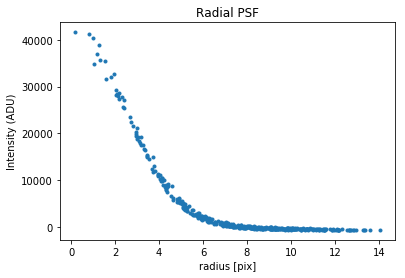

In [291]:
if True:
    plt.ylabel('Intensity (ADU)')
    plt.plot(r_arr_1d, values,'.')
    plt.title('Radial PSF')
    plt.xlabel('radius [pix]')
    plt.show()
    plt.close()